## CORRECT Setup

In [11]:
## SOURCE https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/hello_many_worlds.ipynb
'''
py 3.9
pip3 install --upgrade pip
pip3 install tensorflow==2.11.0
pip3 install -U tensorflow-quantum
pip3 install -U tfq-nightly
ipykernel
'''

'\npy 3.9\npip3 install --upgrade pip\npip3 install tensorflow==2.11.0\npip3 install -U tensorflow-quantum\npip3 install -U tfq-nightly\nipykernel\n'

In [12]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)
import cirq

Now import TensorFlow and the module dependencies:

In [13]:
import tensorflow as tf

import sympy
import cirq
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [14]:
import tensorflow_quantum as tfq


## 1. The Basics

### 1.1 Cirq and parameterized quantum circuits

Before exploring TensorFlow Quantum (TFQ), let's look at some <a target="_blank" href="https://github.com/quantumlib/Cirq" class="external">Cirq</a> basics. Cirq is a Python library for quantum computing from Google. You use it to define circuits, including static and parameterized gates.

Cirq uses <a target="_blank" href="https://www.sympy.org" class="external">SymPy</a> symbols to represent free parameters.

In [15]:
a, b = sympy.symbols('a b')

The following code creates a two-qubit circuit using your parameters:

# TRY CIRCUIT

In [16]:
import cirq

q0, q1, q2 , q3= cirq.GridQubit.rect(1, 4)
qubit = cirq.GridQubit(0, 0)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1),cirq.ry(a).on(q2), cirq.CNOT(control=q2, target=q3), cirq.CNOT(control=q1, target=q0))

print(circuit)
print("Results:")

(0, 0): ───Rx(a)───X───
                   │
(0, 1): ───Ry(b)───@───

(0, 2): ───Ry(a)───@───
                   │
(0, 3): ───────────X───
Results:


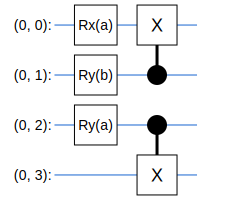

In [17]:
SVGCircuit(circuit)

### 1.2 Quantum circuits as tensors

TensorFlow Quantum (TFQ) provides `tfq.convert_to_tensor`, a function that converts Cirq objects into tensors. This allows you to send Cirq objects to our <a target="_blank" href="https://www.tensorflow.org/quantum/api_docs/python/tfq/layers">quantum layers</a> and <a target="_blank" href="https://www.tensorflow.org/quantum/api_docs/python/tfq/get_expectation_op">quantum ops</a>. The function can be called on lists or arrays of Cirq Circuits and Cirq Paulis:

In [18]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])
print(circuit_tensor.shape)
print(circuit_tensor.dtype)


(1,)
<dtype: 'string'>


This encodes the Cirq objects as `tf.string` tensors that `tfq` operations decode as needed.

## 2. Hybrid quantum-classical optimization

Now that you've seen the basics, let's use TensorFlow Quantum to construct a *hybrid quantum-classical neural net*. You will train a classical neural net to control a single qubit. The control will be optimized to correctly prepare the qubit in the `0` or `1` state, overcoming a simulated systematic calibration error. This figure shows the architecture:

Even without a neural network this is a straightforward problem to solve, but the theme is similar to the real quantum control problems you might solve using TFQ. It demonstrates an end-to-end example of a quantum-classical computation using the `tfq.layers.ControlledPQC` (Parametrized Quantum Circuit) layer inside of a `tf.keras.Model`.

For the implementation of this tutorial, this architecture is split into 3 parts:

- The *input circuit* or *datapoint circuit*: The first three $R$ gates.
- The *controlled circuit*: The other three $R$ gates.
- The *controller*: The classical neural-network setting the parameters of the controlled circuit.

### 2.1 The controlled circuit definition

Define a learnable single bit rotation, as indicated in the figure above. This will correspond to our controlled circuit.

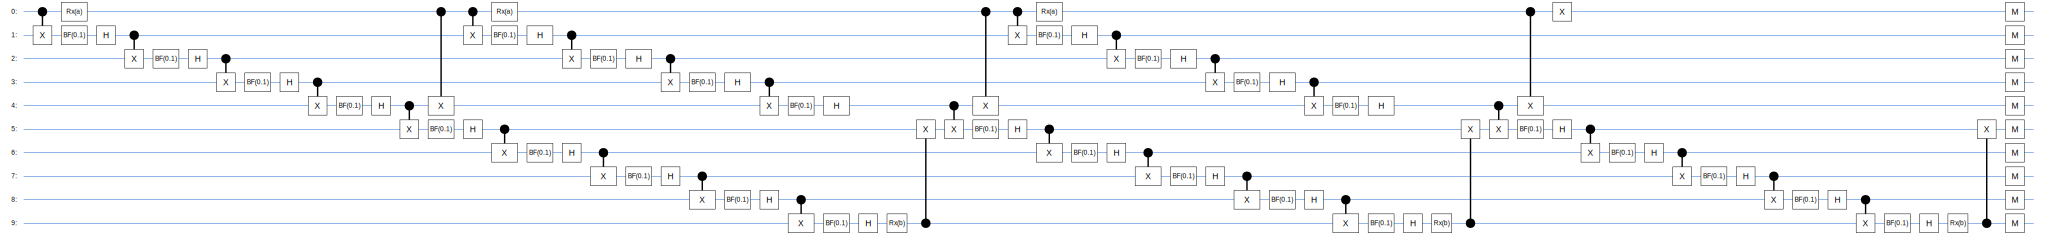

In [19]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('a b')

# Create the parameterized circuit.
def make_GHZ_withbitflips(num_qubits,measurements=True):
    myqubits = cirq.LineQubit.range(num_qubits)
    GHZ_circuit = cirq.Circuit()
        
    
    for u in range(0,3):
        for x in range(num_qubits-1):
            GHZ_circuit.append([cirq.CNOT(myqubits[x],myqubits[x+1]),cirq.bit_flip(p=0.1)(myqubits[x+1])])
            GHZ_circuit.append([cirq.H(myqubits[x+1])])

        GHZ_circuit.append([cirq.rx(a).on(myqubits[0]),cirq.CNOT(myqubits[0],myqubits[4])])
        GHZ_circuit.append([cirq.rx(b).on(myqubits[9]),cirq.CNOT(myqubits[9],myqubits[5])])
        

        x_gate = cirq.X

    if measurements:
        GHZ_circuit.append([x_gate(myqubits[0]),cirq.Moment(cirq.measure_each(*myqubits))])
    return GHZ_circuit

model_circuit=make_GHZ_withbitflips(10)

SVGCircuit(model_circuit)

### 2.2 The controller

Now define controller network: 

In [20]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(2)
])

Given a batch of commands, the controller outputs a batch of control signals for the controlled circuit. 

The controller is randomly initialized so these outputs are not useful, yet.

In [21]:
controller(tf.constant([[0.0],[1.0],[0.0],[1.0]])).numpy()

array([[ 0.        ,  0.        ],
       [-0.33321032,  0.40724027],
       [ 0.        ,  0.        ],
       [-0.33321032,  0.40724027]], dtype=float32)

### 2.3 Connect the controller to the circuit

Use `tfq` to connect the controller to the controlled circuit, as a single `keras.Model`. 

See the [Keras Functional API guide](https://www.tensorflow.org/guide/keras/functional) for more about this style of model definition.

First define the inputs to the model:  

In [22]:
model_circuit.with_noise(cirq.bit_flip(p=0.05))

0: ───@───BF(0.05)[cirq.VirtualTag()]───Rx(a)─────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───@─────────BF(0.05)[cirq.VirtualTag()]───@───BF(0.05)[cirq.VirtualTag()]───Rx(a)─────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───@─────────BF(0.05)[cirq.VirtualTag()]───@───BF(0.05)[cirq.VirtualTag()]───Rx(a)─────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───@─────────BF(0.05)[cirq.VirtualTag()]───X───BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]─────────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───────────BF(0.05)[cirq.VirtualTag()]───────BF(0.05)[cirq.VirtualTag()]───M───BF(0.05)[cirq.VirtualTag()]───
      │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 │                                       │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   │                                       │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [23]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')



Next apply operations to those inputs, to define the computation.

In [24]:
tfq.util.get_supported_channels() 

{cirq.depolarize(p=0.01): 1,
 cirq.asymmetric_depolarize(error_probabilities={'I': 0.94, 'X': 0.01, 'Y': 0.02, 'Z': 0.03}): 1,
 cirq.generalized_amplitude_damp(p=0.01,gamma=0.02): 1,
 cirq.amplitude_damp(gamma=0.01): 1,
 cirq.ResetChannel(): 1,
 cirq.phase_damp(gamma=0.01): 1,
 cirq.phase_flip(p=0.01): 1,
 cirq.bit_flip(p=0.01): 1}

In [25]:
dense_2 = controller(commands_input)


In [26]:

expectation_layer = tfq.layers.NoisyControlledPQC(model_circuit.with_noise(cirq.bit_flip(p=0.05)),
                                             # Observe Z
                                             operators = [cirq.Z(qubit),cirq.Z(qubit)],repetitions=10000,sample_based=True)
expectation = expectation_layer([circuits_input, dense_2])

Now package this computation as a `tf.keras.Model`:

In [27]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)



The network architecture is indicated by the plot of the model below.
Compare this model plot to the architecture diagram to verify correctness.

Note: May require a system install of the `graphviz` package.

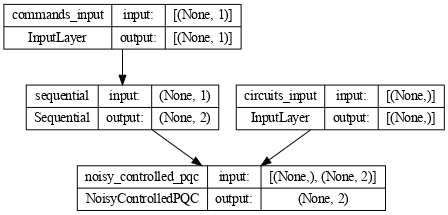

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

This model takes two inputs: The commands for the controller, and the input-circuit whose output the controller is attempting to correct. 

### 2.4 The dataset

The model attempts to output the correct correct measurement value of $\hat{Z}$ for each command. The commands and correct values are defined below.

In [29]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

This is not the entire training dataset for this task. 
Each datapoint in the dataset also needs an input circuit.

### 2.4 Input circuit definition

The input-circuit below defines the random miscalibration the model will learn to correct.

In [30]:
random_rotations = np.random.uniform(0, 2 * np.pi, 100)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

datapoint_circuits.shape


TensorShape([2])

There are two copies of the circuit, one for each datapoint.

### 2.5 Training

With the inputs defined you can test-run the `tfq` model.

ValueError: Data cardinality is ambiguous:
  x sizes: 2, 3
  y sizes: 2
Make sure all arrays contain the same number of samples.

In [31]:
model([datapoint_circuits, commands]).numpy()

array([[0.5134    , 0.51640004],
       [0.5138    , 0.51979995]], dtype=float32)

Now run a standard training process to adjust these values towards the `expected_outputs`.

In [32]:
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=1)

Epoch 1/30
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 19s 19s/step - loss: 1.2645
Epoch 2/30
1/1 [==============================] - 18s 18s/step - loss: 1.2767
Epoch 3/30
1/1 [==============================] - 18s 18s/step - loss: 1.2676
Epoch 4/30
1/1 [==============================] - 18s 18s/step - loss: 1.2753
Epoch 5/30
1/1 [==============================] - 18s 18s/step - loss: 1.2601
Epoch 6/30
1/1 [==============================] - 17s 17s/step - loss: 1.2821
Epoch 7/30
1/1 [==============================] - 17s 17s/step - loss: 1.2725
Epoch 8/30
1/1 [==============================] - 17s 17s/step - loss: 1.2723
Epoch 9/30
1/1 [==============================] - 17s 17s/step - loss: 1.2653
Epoch 10/30
1/1 [==============================] - 17s 17s/step - loss: 1.2719
Epoch 11/30
1/1 [=

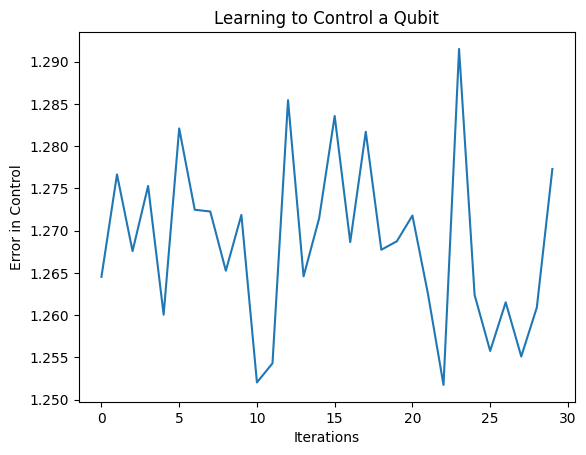

In [33]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

From this plot you can see that the neural network has learned to overcome the systematic miscalibration.

### 2.6 Verify outputs
Now use the trained model, to correct the qubit calibration errors. With Cirq:

In [34]:
control_params

(a, b)

In [35]:
params_to_prepare_output = controller(commands).numpy()
full_circuit = noisy_preparation + model_circuit
print(full_circuit)

(0, 0): ───Rx(0.039π)───Ry(0.325π)───Rz(0.547π)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

0: ───────────────────────────────────────────────@───Rx(a)───────────────────────────────────────────────────────────────────@─────────@───Rx(a)───────────────────────────────────────────────────────────────────────────────────────────────────────────@─────────@───Rx(a)───────────────────────────────────────────────────────────────────────────────────────────────────────────@─────────X───────────────────────────────────────────────────────────────────────────────────────M───
                                     

In [36]:
cirq_simulator = cirq.Simulator()

def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state_vector
    expt = cirq.Z(qubit).expectation_from_state_vector(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expt}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [-0.43385428  0.22177477]
Which gives an actual expectation of: 0.519564688205719

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-1.3351285  0.8036386]
Which gives an actual expectation of: 0.5195654034614563



The value of the loss function during training provides a rough idea of how well the model is learning. The lower the loss, the closer the expectation values in the above cell is to `desired_values`. If you aren't as concerned with the parameter values, you can always check the outputs from above using `tfq`:

In [37]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5196    , 0.5228    ],
       [0.51780003, 0.5194    ]], dtype=float32)>